# **Import Libraries**

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score, f1_score, precision_score, recall_score
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.regularizers import l2

import cv2

In [3]:
train_dir = "/content/drive/MyDrive/Urban_Sound/images"

# **Load Data and Preprocessing**

In [4]:
def load_images(directory):
    images = []
    labels = []
    successed = 0
    fail = 0
    try:
      for idx, label in enumerate(uniq_labels):
          for file in os.listdir(directory + "/" + label):
              filepath = directory + "/" + label + "/" + file
              image = cv2.resize(cv2.imread(filepath), (64, 64))
              image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              image = image/255
              images.append(image)
              labels.append(idx)
              print(f"\r File Name: {file} - Successed: {successed}", end="")
              successed +=1
      images = np.array(images)
      labels = np.array(labels)
    except:
      fail +=1
      print(fail)
    return(images, labels)

In [5]:
uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

 File Name: 99710-9-0-5.png - Successed: 8731

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=42, test_size = 0.1, stratify = labels)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, random_state=42, test_size = 0.11)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)
eval_n = len(X_eval)

print("Total number of classes: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)
print("Number of evaluation images: ", eval_n)

Total number of classes:  10
Number of training images:  6993
Number of testing images:  874
Number of evaluation images:  865


In [7]:
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)
y_eval = keras.utils.np_utils.to_categorical(y_eval)

# **Helper Functions For Model Training**

In [8]:
def train_model(model, X_train, y_train, X_test, y_test):
  optimiser = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  callbacks = [ ReduceLROnPlateau(monitor='val_loss',
                                patience=4,
                                cooldown=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=5)]

  from datetime import datetime
  now = datetime.now()
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = callbacks, batch_size=32, epochs=50)
  print(datetime.now() - now)

  return history

In [9]:
def model_performance(model, X_test, y_test, X_eval, y_eval):
  score = model.evaluate(x = X_test, y = y_test, verbose = 0)
  print('Accuracy for test images:', round(score[1]*100, 3), '%')
  score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
  print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')


  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred,axis = 1)
  y_true = np.argmax(y_test,axis = 1)

  target_names = ["Air Conditioner", "Car Horn", "Children Playing", "Dog Bark", "Drilling", "Engine Idling", "Gun Shot","Jackhammer", "Siren", "Street Music"]

  print(classification_report(y_true, y_pred_classes, target_names = target_names))

  y_pred = model.predict(X_eval)
  y_pred_classes = np.argmax(y_pred,axis = 1)
  y_true = np.argmax(y_eval, axis = 1)

  target_names = ["Air Conditioner", "Car Horn", "Children Playing", "Dog Bark", "Drilling", "Engine Idling", "Gun Shot","Jackhammer", "Siren", "Street Music"]

  print(classification_report(y_true, y_pred_classes, target_names = target_names))

In [10]:
def plot_training(model_history):
  fig , ax = plt.subplots(1,2)
  train_acc = model_history.history['accuracy']
  train_loss = model_history.history['loss']
  fig.set_size_inches(12,4)

  ax[0].plot(model_history.history['accuracy'])
  ax[0].plot(model_history.history['val_accuracy'])
  ax[0].set_title('Training Accuracy vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], loc='upper left')

  ax[1].plot(model_history.history['loss'])
  ax[1].plot(model_history.history['val_loss'])
  ax[1].set_title('Training Loss vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], loc='upper left')

# **MODEL**

## **MLP**

In [11]:
def mlp_model(input_shape, dense, l2_score, num_classes, droput_rate):
  dense1, dense2, dense3 = dense

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape = input_shape))
  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Dense(dense1, activation='relu', kernel_regularizer=l2(l2_score)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(droput_rate))

  model.add(keras.layers.Dense(dense2, activation='relu', kernel_regularizer=l2(l2_score)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(droput_rate))

  model.add(keras.layers.Dense(dense3, activation='relu', kernel_regularizer=l2(l2_score)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(droput_rate))

  model.add(keras.layers.Dense(num_classes, activation='softmax'))

  return model


model_mlp = mlp_model((64,64), (512, 256, 64), 0.0001, 10, 0.3)

In [12]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               2097664   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [13]:
model_mlp_history = train_model(model_mlp, X_train, y_train, X_test, y_test)

Epoch 1/50
219/219 [==============================] - 6s 8ms/step - loss: 2.3136 - accuracy: 0.3040 - val_loss: 1.8792 - val_accuracy: 0.4176 - lr: 1.0000e-04
Epoch 2/50
219/219 [==============================] - 1s 6ms/step - loss: 1.8294 - accuracy: 0.4397 - val_loss: 1.4512 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 3/50
219/219 [==============================] - 1s 6ms/step - loss: 1.6602 - accuracy: 0.4849 - val_loss: 1.3162 - val_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 4/50
219/219 [==============================] - 2s 8ms/step - loss: 1.5654 - accuracy: 0.5232 - val_loss: 1.2492 - val_accuracy: 0.6339 - lr: 1.0000e-04
Epoch 5/50
219/219 [==============================] - 2s 8ms/step - loss: 1.4722 - accuracy: 0.5518 - val_loss: 1.1968 - val_accuracy: 0.6625 - lr: 1.0000e-04
Epoch 6/50
219/219 [==============================] - 1s 6ms/step - loss: 1.4206 - accuracy: 0.5709 - val_loss: 1.1723 - val_accuracy: 0.6751 - lr: 1.0000e-04
Epoch 7/50
219/219 [==========================

In [14]:
model_performance(model_mlp, X_test, y_test, X_eval, y_eval)

Accuracy for test images: 77.231 %
Accuracy for evaluation images: 76.185 %
28/28 [==============================] - 0s 2ms/step
                  precision    recall  f1-score   support

 Air Conditioner       0.77      0.85      0.81       100
        Car Horn       0.92      0.77      0.84        43
Children Playing       0.56      0.54      0.55       100
        Dog Bark       0.71      0.65      0.68       100
        Drilling       0.86      0.92      0.89       100
   Engine Idling       0.80      0.90      0.85       100
        Gun Shot       0.95      0.92      0.93        38
      Jackhammer       0.86      0.90      0.88       100
           Siren       0.85      0.74      0.79        93
    Street Music       0.64      0.62      0.63       100

        accuracy                           0.77       874
       macro avg       0.79      0.78      0.78       874
    weighted avg       0.77      0.77      0.77       874

28/28 [==============================] - 0s 2ms/step
   

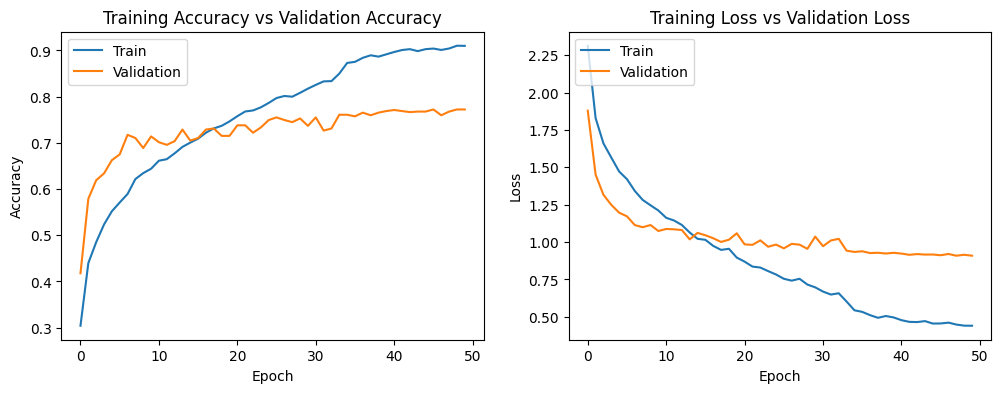

In [17]:
plot_training(model_mlp_history)

In [18]:
model_mlp.save("model_mlp.h5")

## **LSTM**

In [19]:
model_lstm = keras.Sequential()

model_lstm.add(keras.layers.LSTM(64, input_shape=(64, 64), kernel_regularizer=l2(0.0001), return_sequences=True))
model_lstm.add(keras.layers.Dropout(0.3))
model_lstm.add(keras.layers.LSTM(64, kernel_regularizer=l2(0.0001)))

model_lstm.add(keras.layers.Dense(64, activation='relu'))
model_lstm.add(keras.layers.BatchNormalization())
model_lstm.add(keras.layers.Dropout(0.3))

model_lstm.add(keras.layers.Dense(64, activation='relu'))
model_lstm.add(keras.layers.BatchNormalization())
model_lstm.add(keras.layers.Dropout(0.3))

model_lstm.add(keras.layers.Dense(64, activation='relu'))
model_lstm.add(keras.layers.BatchNormalization())
model_lstm.add(keras.layers.Dropout(0.3))

model_lstm.add(keras.layers.Dense(10, activation='softmax'))

In [20]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            33024     
                                                                 
 dropout_3 (Dropout)         (None, 64, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [21]:
model_lstm_history = train_model(model_lstm, X_train, y_train, X_test, y_test)

Epoch 1/50
219/219 [==============================] - 8s 15ms/step - loss: 2.9439 - accuracy: 0.1237 - val_loss: 2.3860 - val_accuracy: 0.1144 - lr: 1.0000e-04
Epoch 2/50
219/219 [==============================] - 3s 14ms/step - loss: 2.5668 - accuracy: 0.1823 - val_loss: 2.0617 - val_accuracy: 0.2906 - lr: 1.0000e-04
Epoch 3/50
219/219 [==============================] - 3s 12ms/step - loss: 2.3707 - accuracy: 0.2159 - val_loss: 1.9070 - val_accuracy: 0.3330 - lr: 1.0000e-04
Epoch 4/50
219/219 [==============================] - 2s 11ms/step - loss: 2.2793 - accuracy: 0.2432 - val_loss: 1.8347 - val_accuracy: 0.3524 - lr: 1.0000e-04
Epoch 5/50
219/219 [==============================] - 2s 11ms/step - loss: 2.1915 - accuracy: 0.2525 - val_loss: 2.1687 - val_accuracy: 0.3410 - lr: 1.0000e-04
Epoch 6/50
219/219 [==============================] - 2s 10ms/step - loss: 2.1630 - accuracy: 0.2558 - val_loss: 1.7942 - val_accuracy: 0.3650 - lr: 1.0000e-04
Epoch 7/50
219/219 [====================

In [22]:
model_performance(model_lstm, X_test, y_test, X_eval, y_eval)

Accuracy for test images: 47.254 %
Accuracy for evaluation images: 48.324 %
28/28 [==============================] - 1s 6ms/step
                  precision    recall  f1-score   support

 Air Conditioner       0.29      0.53      0.38       100
        Car Horn       0.27      0.07      0.11        43
Children Playing       0.33      0.27      0.30       100
        Dog Bark       0.68      0.45      0.54       100
        Drilling       0.79      0.56      0.65       100
   Engine Idling       0.63      0.27      0.38       100
        Gun Shot       0.78      0.66      0.71        38
      Jackhammer       0.44      0.70      0.54       100
           Siren       0.56      0.52      0.54        93
    Street Music       0.40      0.59      0.48       100

        accuracy                           0.47       874
       macro avg       0.52      0.46      0.46       874
    weighted avg       0.52      0.47      0.47       874

28/28 [==============================] - 0s 5ms/step
   

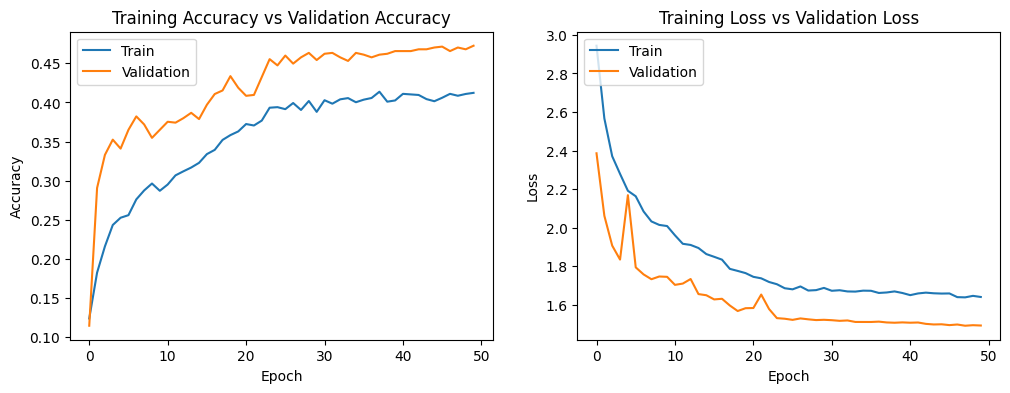

In [23]:
plot_training(model_lstm_history)

In [24]:
model_lstm.save("model_lstm.h5")

## **CNN**

In [25]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.0001)))
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))


model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [26]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)      

In [27]:
model_cnn_history = train_model(model_cnn, X_train, y_train, X_test, y_test)

Epoch 1/50
219/219 [==============================] - 14s 33ms/step - loss: 2.0327 - accuracy: 0.3456 - val_loss: 2.5194 - val_accuracy: 0.1144 - lr: 1.0000e-04
Epoch 2/50
219/219 [==============================] - 5s 23ms/step - loss: 1.4663 - accuracy: 0.5125 - val_loss: 3.1319 - val_accuracy: 0.1705 - lr: 1.0000e-04
Epoch 3/50
219/219 [==============================] - 4s 17ms/step - loss: 1.2413 - accuracy: 0.5943 - val_loss: 2.4911 - val_accuracy: 0.2654 - lr: 1.0000e-04
Epoch 4/50
219/219 [==============================] - 4s 17ms/step - loss: 1.1031 - accuracy: 0.6391 - val_loss: 1.6573 - val_accuracy: 0.4908 - lr: 1.0000e-04
Epoch 5/50
219/219 [==============================] - 4s 18ms/step - loss: 1.0012 - accuracy: 0.6785 - val_loss: 1.2369 - val_accuracy: 0.6007 - lr: 1.0000e-04
Epoch 6/50
219/219 [==============================] - 4s 17ms/step - loss: 0.9087 - accuracy: 0.7050 - val_loss: 1.2129 - val_accuracy: 0.6178 - lr: 1.0000e-04
Epoch 7/50
219/219 [===================

In [28]:
model_performance(model_cnn, X_test, y_test, X_eval, y_eval)

Accuracy for test images: 78.032 %
Accuracy for evaluation images: 81.618 %
28/28 [==============================] - 0s 4ms/step
                  precision    recall  f1-score   support

 Air Conditioner       0.89      0.57      0.70       100
        Car Horn       1.00      0.79      0.88        43
Children Playing       0.73      0.83      0.78       100
        Dog Bark       0.98      0.59      0.74       100
        Drilling       0.84      0.77      0.80       100
   Engine Idling       0.74      0.80      0.77       100
        Gun Shot       0.90      0.95      0.92        38
      Jackhammer       0.58      0.98      0.73       100
           Siren       0.95      0.74      0.83        93
    Street Music       0.74      0.89      0.81       100

        accuracy                           0.78       874
       macro avg       0.83      0.79      0.80       874
    weighted avg       0.82      0.78      0.78       874

28/28 [==============================] - 0s 4ms/step
   

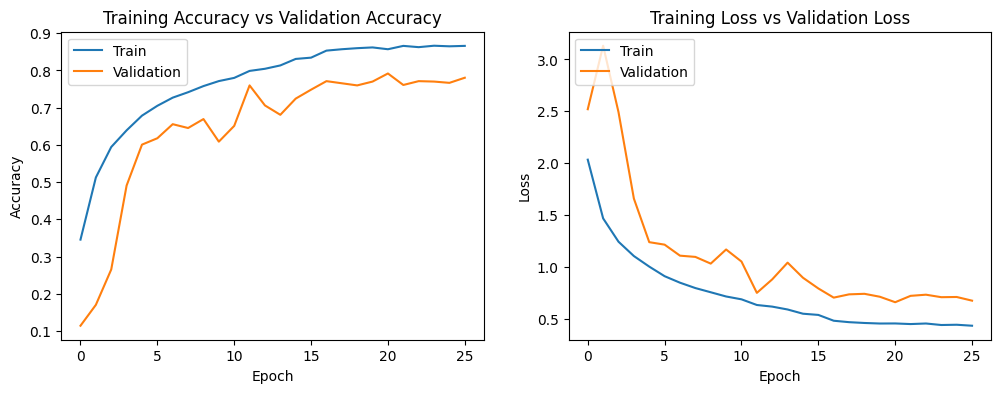

In [29]:
plot_training(model_cnn_history)

In [30]:
model_cnn.save("model_cnn.h5")

## **Parallel CNN**


In [31]:
from keras.layers import concatenate

input = keras.Input(shape=(64, 64, 1), name="input")
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(input)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)


x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

out1 = keras.layers.Dense(64, activation='relu')(x)



# Model 2

x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(input)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)


x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))(x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

out2 = keras.layers.Dense(64, activation='relu')(x)



concatenated  = concatenate([out1, out2])
flattened = keras.layers.Flatten()(concatenated)
flattened = keras.layers.Dense(128, activation='relu')(flattened)
output = keras.layers.Dense(10, activation='softmax')(flattened)


model_parallel_cnn = keras.Model(inputs=input, outputs=output)

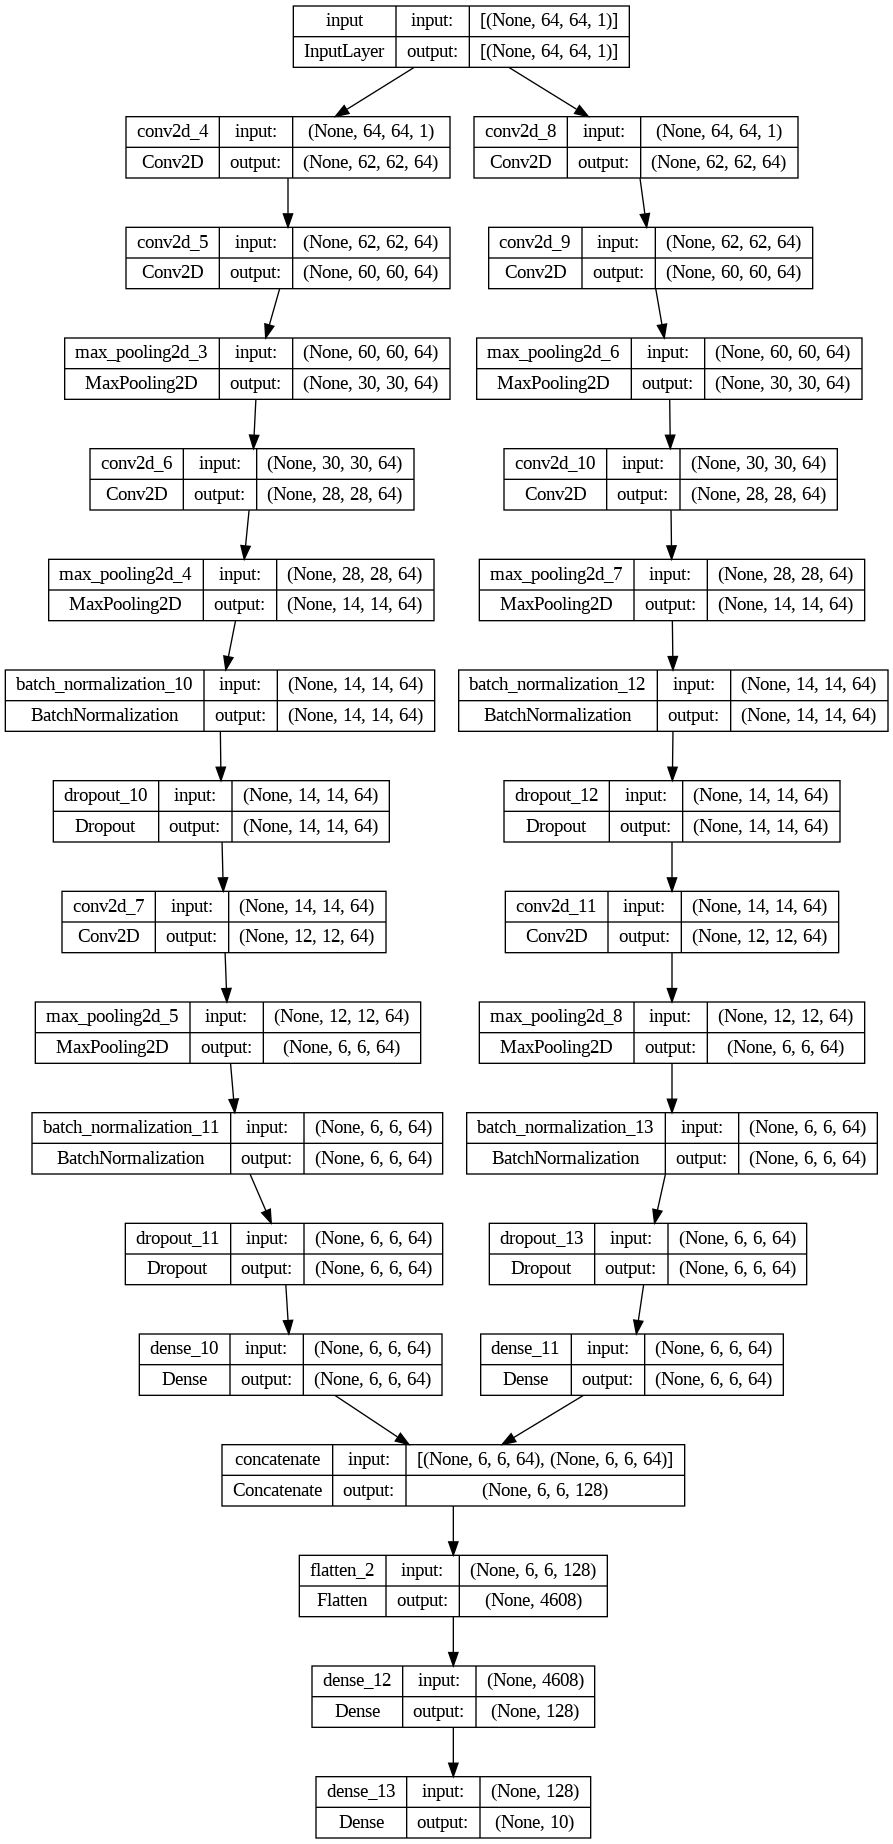

In [32]:
keras.utils.plot_model(model_parallel_cnn, "model.png", show_shapes=True)

In [33]:
model_parallel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 62, 62, 64)   640         ['input[0][0]']                  
                                                                                                  
 conv2d_8 (Conv2D)              (None, 62, 62, 64)   640         ['input[0][0]']                  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 60, 60, 64)   36928       ['conv2d_4[0][0]']               
                                                                                              

In [34]:
model_parallel_cnn_history = train_model(model_parallel_cnn, X_train, y_train, X_test, y_test)

Epoch 1/50
219/219 [==============================] - 9s 34ms/step - loss: 1.5022 - accuracy: 0.4892 - val_loss: 3.3030 - val_accuracy: 0.1167 - lr: 1.0000e-04
Epoch 2/50
219/219 [==============================] - 7s 31ms/step - loss: 0.9740 - accuracy: 0.6784 - val_loss: 4.5075 - val_accuracy: 0.1499 - lr: 1.0000e-04
Epoch 3/50
219/219 [==============================] - 7s 32ms/step - loss: 0.7937 - accuracy: 0.7486 - val_loss: 1.9312 - val_accuracy: 0.4691 - lr: 1.0000e-04
Epoch 4/50
219/219 [==============================] - 7s 31ms/step - loss: 0.6715 - accuracy: 0.7909 - val_loss: 1.2108 - val_accuracy: 0.6007 - lr: 1.0000e-04
Epoch 5/50
219/219 [==============================] - 7s 32ms/step - loss: 0.5927 - accuracy: 0.8154 - val_loss: 0.7795 - val_accuracy: 0.7677 - lr: 1.0000e-04
Epoch 6/50
219/219 [==============================] - 7s 31ms/step - loss: 0.5075 - accuracy: 0.8464 - val_loss: 0.6519 - val_accuracy: 0.8101 - lr: 1.0000e-04
Epoch 7/50
219/219 [====================

In [35]:
model_performance(model_parallel_cnn, X_test, y_test, X_eval, y_eval)

Accuracy for test images: 88.673 %
Accuracy for evaluation images: 89.48 %
28/28 [==============================] - 0s 8ms/step
                  precision    recall  f1-score   support

 Air Conditioner       0.89      0.90      0.90       100
        Car Horn       0.98      0.95      0.96        43
Children Playing       0.88      0.83      0.86       100
        Dog Bark       1.00      0.76      0.86       100
        Drilling       0.84      0.87      0.86       100
   Engine Idling       0.87      0.94      0.90       100
        Gun Shot       0.90      0.97      0.94        38
      Jackhammer       0.85      0.94      0.90       100
           Siren       0.94      0.88      0.91        93
    Street Music       0.81      0.91      0.86       100

        accuracy                           0.89       874
       macro avg       0.90      0.90      0.89       874
    weighted avg       0.89      0.89      0.89       874

28/28 [==============================] - 0s 8ms/step
    

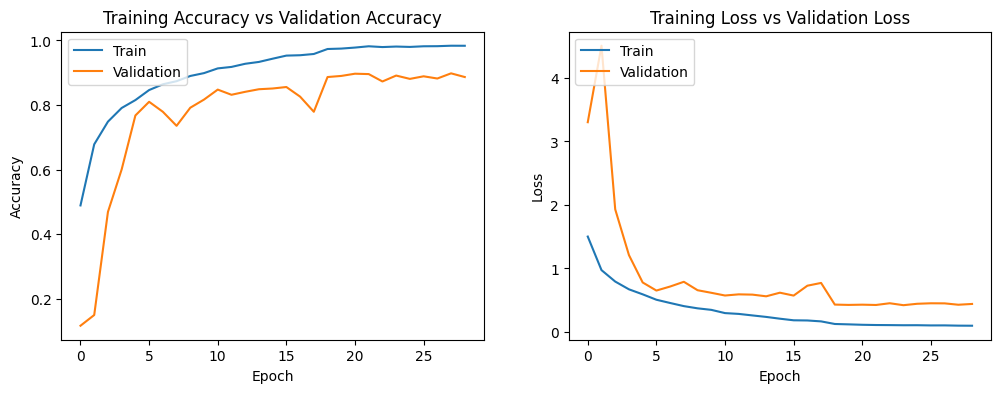

In [36]:
plot_training(model_parallel_cnn_history)

In [37]:
model_parallel_cnn.save("model_parallel_cnn.h5")